# Imports

In [8]:
import os, sys, time, json, csv, math, difflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tif
from scipy.ndimage.interpolation import zoom

sys.path.append("../../src")
from utils.atlases import reformat, replace_with_common_name, check_for_syn, get_parent_id_from_praid, get_hierarchy, get_dissimilarity

import warnings
warnings.simplefilter('ignore')

# User Inputs

In [33]:
# load label csvs 
labels_dir = '/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/'

# this is the file we want to relate to the PRA
lab_pma = pd.read_csv(os.path.join(labels_dir,'PMA_anns.csv'))

# load PRA files
syns = pd.read_csv(os.path.join(labels_dir,'syns_with_parents.csv'))
PRAlabs = pd.read_csv(os.path.join(labels_dir,'PRA_labels.csv'))

# load json
with open(os.path.join(labels_dir,'PRA_ontology.json')) as f:
 ontology = json.load(f)

# Example of how to take a labeled volume and relate to PRA

In [34]:
lab_atl = lab_pma.copy()[['name', 'id']]
lab_atl.columns=['label','ID']

In [35]:
lab_atl.insert(2,'common_name','null')
lab_atl.insert(2,'name','null')
lab_atl

,label,ID,name,common_name
0,"Tuberomammillary nucleus, ventral part",1,null,null
1,"Primary somatosensory area, mouth, layer 6b",2,null,null
2,secondary fissure,3,null,null
3,Inferior colliculus,4,null,null
4,internal capsule,6,null,null
...,...,...,...,...
1325,"Interpeduncular nucleus, intermediate",607344850,null,null
1326,"Interpeduncular nucleus, dorsomedial",607344854,null,null
1327,"Interpeduncular nucleus, dorsolateral",607344858,null,null
1328,"Interpeduncular nucleus, rostrolateral",607344862,null,null


In [36]:
lab_atl[lab_atl.index==128]

,label,ID,name,common_name
128,pallidotegmental fascicle,134,null,null


In [37]:
manual_check=[]
for i in lab_atl.index:
    lab_atl.at[i,'name']=reformat(lab_atl.label[i])
    nm=lab_atl.at[i,'name']
    if nm in list(syns.common_name):
        #print('if')
        lab_atl.at[i,'common_name']=nm
    elif nm in list(syns.name):
        #print('elif')
        lab_atl.at[i,'common_name']=list(syns.common_name[syns.name==nm])[0]
    else:
        manual_check.append(i)

In [38]:
manual_check

[]

In [39]:
# for each element of manual_check, we print the name, and closest options
# add to syns csv, and re-import!
for idval in manual_check:
    print(list(lab_atl[lab_atl.index==idval]['name'])[0])
    print(difflib.get_close_matches(list(lab_atl[lab_atl.index==idval]['name'])[0],list(PRAlabs.name),n=20,cutoff=0.1))

In [40]:
ontology.keys()

dict_keys(['id', 'common_name', 'graph_order', 'parent_structure_id', 'children'])

In [41]:
PRAlabs

,Unnamed: 0,id,name,parent_id,parent_name,family_tree,family_struct
0,0,273,abducens_nucleus,285,medulla_mot,"[0, 37, 59, 91, 13, 189, 285, 273]",/0/37/59/91/13/189/285/273
1,1,566,supraoptic_group_accessory,11,hypothalamus,"[0, 37, 59, 91, 11, 566]",/0/37/59/91/11/566
2,2,475,accumbens_nucleus,607,striatum_ventral_region,"[0, 37, 66, 34, 61, 607, 475]",/0/37/66/34/61/607/475
3,3,78,acoustic_striae,549,cochlear_nerve,"[0, 6, 616, 549, 78]",/0/6/616/549/78
4,4,232,agranular_insular_cortex,150,insular_cortex,"[0, 37, 59, 150, 232]",/0/37/59/150/232
...,...,...,...,...,...,...,...
622,622,297,vestibular_nuclei,285,medulla_mot,"[0, 37, 59, 91, 13, 189, 285, 297]",/0/37/59/91/13/189/285/297
623,623,298,vestibular_nucleus_efferent,285,medulla_mot,"[0, 37, 59, 91, 13, 189, 285, 298]",/0/37/59/91/13/189/285/298
624,624,616,vestibulocochlear_nerve,6,cochlea,"[0, 6, 616]",/0/6/616
625,625,237,visual_cortex,59,cortex,"[0, 37, 59, 237]",/0/37/59/237


In [42]:
# great! now we have common_names that match our PRA ID info. 
# Merge that info into your volume labels.
lab_atl=lab_atl.assign(praid=0,structure_id_path='0')
lab_atl

,label,ID,name,common_name,praid,structure_id_path
0,"Tuberomammillary nucleus, ventral part",1,tuberomammillary_nucleus_ventral_part,hypothalamus_tuberomammillary_nucleus,0,0
1,"Primary somatosensory area, mouth, layer 6b",2,primary_somatosensory_area_mouth_layer_6b,primary_somatosensory_cortex,0,0
2,secondary fissure,3,secondary_fissure,secondary_fissure,0,0
3,Inferior colliculus,4,inferior_colliculus,inferior_colliculus,0,0
4,internal capsule,6,internal_capsule,internal_capsule,0,0
...,...,...,...,...,...,...
1325,"Interpeduncular nucleus, intermediate",607344850,interpeduncular_nucleus_intermediate,interpeduncular_nucleus,0,0
1326,"Interpeduncular nucleus, dorsomedial",607344854,interpeduncular_nucleus_dorsomedial,interpeduncular_nucleus,0,0
1327,"Interpeduncular nucleus, dorsolateral",607344858,interpeduncular_nucleus_dorsolateral,interpeduncular_nucleus,0,0
1328,"Interpeduncular nucleus, rostrolateral",607344862,interpeduncular_nucleus_rostrolateral,interpeduncular_nucleus,0,0


In [43]:
# id, family struct

In [44]:
for idx in lab_atl.index:
    atl_nm = lab_atl.common_name[idx]
    try:
        lab_atl.structure_id_path[idx] = PRAlabs[PRAlabs.name==atl_nm]['family_struct'].tolist()[0]
        lab_atl.praid=PRAlabs[PRAlabs.name==atl_nm]['id'].tolist()[0]
    except:
        print(atl_nm)

In [46]:
lab_atl.to_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PMA_in_PRA.csv')

# random color thing, needs to be moved to cell plotting 

In [432]:
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]

In [433]:
colors

[[255, 255, 255],
 [140, 78, 153],
 [111, 76, 155],
 [96, 89, 169],
 [85, 104, 184],
 [78, 121, 197],
 [77, 138, 198],
 [78, 150, 188],
 [84, 158, 179],
 [89, 165, 169],
 [96, 171, 158],
 [105, 177, 144],
 [119, 183, 125],
 [140, 188, 104],
 [166, 190, 84],
 [190, 188, 72],
 [209, 181, 65],
 [221, 170, 60],
 [228, 156, 57],
 [231, 140, 53],
 [230, 121, 50],
 [228, 99, 45],
 [223, 72, 40],
 [218, 34, 34],
 [255, 255, 255]]

In [434]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


In [435]:
from matplotlib.colors import ListedColormap

colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)

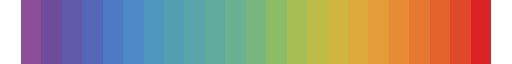

In [436]:
cell_rainbow